In [15]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pyAgrum as gum
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
table = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa']].loc[~df['cid10_faixa'].isnull()]
table = table.fillna('Sem')

Para da inicio as predições é necessário utilizar um encoder adequado para os dados, por se tratarem de categorias independentes, ou seja, não possuem ordem, será utilizaro o OneHotEncoder que transforma cada categoria em uma coluna de valores binarios.

In [3]:
encX = OneHotEncoder()
ency = OneHotEncoder()

X = table[['cid10_faixa', 'cid10_seg_faixa']]
X = encX.fit_transform(X)
y = np.array(table['cid10_faixa_alta'])
# y = ency.fit_transform(y).reshape(-1, 1)

Para fazer análises mais profundas de configurações podemos separar nossos dados em  treino, teste e validação, porém neste primeiro momento vamos utilizar apenas treino e teste por se tratar de uma abordagem mais simplista inicialmente. Contúdo uma função para as três separações já pode ser mantida pronta.

In [4]:
def train_test_val_split(X, y, test_size=None, val_size = None,random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
    
    return X_train.toarray(), X_test.toarray(), X_val.toarray(), y_train, y_test, y_val

# X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X, y, test_size=0.2, val_size = 0.05,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, = X_train.toarray(), X_test.toarray()

In [5]:
print(X_train.shape)
X_train

(6574, 23)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
print(y_train.shape)
y_train

(6574,)


array(['F10-F19', 'F10-F19', 'F20-F29', ..., 'F10-F19', 'F30-F39',
       'F30-F39'], dtype=object)

Serão utilizados modelos explicativos em um primeiro momento para mantermos a explicabilidade das predições.

Os dois modelos escolhidos foram NaiveBayes e DecisionTree por serem algoritmos básicos porém eficazes.

Será utilizado também um modelo baseline para comparação.

In [7]:
# Avaliação dos modelos
def evaluate(y_pred, y_test):
    acuracia = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted')

    print('Resultados:')
    print(f'    Acuracia: {acuracia}')
    print(f'    F1: {f1}')
    return acuracia, f1

In [8]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
acuracia_dummy, f1_dummy = evaluate(y_pred, y_test)

Resultados:
    Acuracia: 0.37165450121654503
    F1: 0.5419068736141907


In [9]:
nb = CategoricalNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
acuracia_nb, f1_nb = evaluate(y_pred, y_test)

Resultados:
    Acuracia: 0.7390510948905109
    F1: 0.7488247891294786


Para a Árvore de Decisão será utilizado GridSearch para encontrar os melhores parâmetros dentro de um escopo que pode ser escolhido.

Vale lembrar que GridSearch testa cada combinação de parâmetros passados em um K-Fold Cross Validation, utilizando a combinação que melhor desempenhar.
Neste caso serão 5 folds com a métrica F1 balanceada.

In [10]:
tc = DecisionTreeClassifier(random_state=42)
param_tc = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': range(5, 20, 1)}


gs_tc = GridSearchCV(tc, param_tc, cv=5, scoring='f1_weighted')


best_model = gs_tc.fit(X_train, y_train)
print(best_model.best_params_)

C:\Users\Eduardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


{'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}


In [ ]:
# Gerador de imagem pra a árvore

# Definindo os labels das features
model = DecisionTreeClassifier(random_state=42, criterion=best_model.best_params_['criterion'], max_depth=best_model.best_params_['max_depth'], splitter=best_model.best_params_['splitter'])
model.fit(X_train, y_train)
df2 = pd.DataFrame(encX.inverse_transform(X_train), columns=['cid10_faixa', 'cid10_seg_faixa'])
labels = df2['cid10_faixa'].apply(lambda x: 'cid10_faixa_' + x).unique().tolist()
labels.extend(df2['cid10_seg_faixa'].apply(lambda x: 'cid10_seg_faixa_' + x).unique().tolist())
labels

#Gerando o gráfico
dot_data = export_graphviz(model, out_file=None, 
                           feature_names=labels,  
                           class_names=np.unique(y_train).tolist(),  
                           filled=True, rounded=True,  
                           special_characters=True)  

graph = graphviz.Source(dot_data)
graph.render("iris_tree")

In [12]:
y_pred = best_model.predict(X_test)
acuracia_dt, f1_dt = evaluate(y_pred, y_test)

Resultados:
    Acuracia: 0.7402676399026764
    F1: 0.7511145511008342


In [13]:
resultados = pd.DataFrame()
resultados['NaiveBayes'] = pd.Series([acuracia_nb, f1_nb])
resultados['DecisionTree'] = pd.Series([acuracia_dt, f1_dt])
resultados['Dummy'] = pd.Series([acuracia_dummy, f1_dummy])
resultados.index = ['Acuracia', 'F1 Balanceado']
resultados

,NaiveBayes,DecisionTree,Dummy
Acuracia,0.739051,0.740268,0.371655
F1 Balanceado,0.748825,0.751115,0.541907


### Rede Bayesiana

In [54]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pyAgrum as gum
import pyAgrum.lib.explain as explain
from sklearn.dummy import DummyClassifier
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bnvsbn


In [55]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa']].loc[~df['cid10_faixa'].isnull()]
diagnosticos = diagnosticos.fillna('Sem')

diagnosticos_plus = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo',
                        'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']].loc[~df['cid10_faixa'].isnull()]
diagnosticos_plus = diagnosticos_plus.fillna('Sem')

#### Rede Resumida

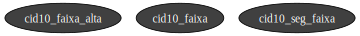

In [56]:
# Template das variáveis a serem utilizadas
template = gum.BayesNet()
template.add(gum.LabelizedVariable("cid10_faixa", "Primeiro diagnóstico do paciente", diagnosticos['cid10_faixa'].unique().tolist()))
template.add(gum.LabelizedVariable("cid10_seg_faixa", "Segundo diagnóstico do paciente", diagnosticos['cid10_seg_faixa'].unique().tolist()))
template.add(gum.LabelizedVariable("cid10_faixa_alta", "Diagnóstico de alta do paciente", diagnosticos['cid10_faixa_alta'].unique().tolist()))

gnb.showBN(template)

Aqui criamos uma rede que deve utilizar os dois diagnósticos de entrada do paciente para tentar predizer o diagnóstico do paciente no momento que ele recebe alta do hospital.

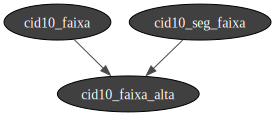

In [57]:
# Rede modelo de base
bn=gum.fastBN("cid10_faixa->cid10_faixa_alta;cid10_seg_faixa->cid10_faixa_alta")
gnb.showBN(bn)

In [58]:
# Rede aprendida
learner = gum.BNLearner(diagnosticos, template)
bn1 = learner.learnBN()
bn1

(pyAgrum.BayesNet<double>@0000020BF40944B0) BN{nodes: 3, arcs: 2, domainSize: 1584, dim: 263, mem: 2Ko 248o}

O modelo aprendeu uma rede diferente da que foi proposta. A partir do modelo aprendido podemos interpretar que o primeiro diagnostico é útil para prever o diagnóstico do paciente no momento de alta, porém o segundo diagnóstico não é muito efetivo para esse propósito. Em vez disso, parece ser melhor fazer o contrário, utilizar o diagnóstico de alta do paciente para descobrir qual foi o segundo diagnóstico com que o paciente foi admitido no hospital.

In [59]:
# Probabilidades conjuntas em cid10_faixa_alta
bn1.cpt('cid10_faixa_alta')

(pyAgrum.Potential<double>@0000020BF4B06E90) 
      ||  cid10_faixa_alta                                                                                                     |
cid10_||F10-F19  |F60-F69  |F30-F39  |F01-F09  |F20-F29  |F70-F79  |Sem      |F90-F98  |F40-F49  |F99-F99  |F50-F59  |F80-F89  |
------||---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
F10-F1|| 0.8859  | 0.0118  | 0.0311  | 0.0037  | 0.0396  | 0.0108  | 0.0051  | 0.0108  | 0.0007  | 0.0000  | 0.0000  | 0.0003  |
F60-F6|| 0.1202  | 0.5912  | 0.1899  | 0.0096  | 0.0216  | 0.0120  | 0.0120  | 0.0072  | 0.0361  | 0.0000  | 0.0000  | 0.0000  |
F30-F3|| 0.0876  | 0.1039  | 0.6922  | 0.0133  | 0.0635  | 0.0108  | 0.0074  | 0.0020  | 0.0167  | 0.0010  | 0.0015  | 0.0000  |
F70-F7|| 0.0918  | 0.0255  | 0.0510  | 0.0561  | 0.0816  | 0.6426  | 0.0204  | 0.0153  | 0.0051  | 0.0000  | 0.0000  | 0.0102  |
F20-F2|| 0.1081  | 0.0431  | 0.1266  | 0.0299  | 0.6237  | 0.0391  | 0.0132  | 0.0031  | 0.0106  | 0.0018  | 0.0000  | 0.0009  |
F01-F0|| 0.1232  | 0.0427  | 0.1090  | 0.4690  | 0.0900  | 0.0758  | 0.0664  | 0.0000  | 0.0142  | 0.0048  | 0.0000  | 0.0048  |
F40-F4|| 0.0448  | 0.2237  | 0.2088  | 0.0150  | 0.1044  | 0.0150  | 0.0001  | 0.0001  | 0.3876  | 0.0001  | 0.0001  | 0.0001  |
F90-F9|| 0.1363  | 0.0682  | 0.1136  | 0.0455  | 0.0229  | 0.1363  | 0.0229  | 0.4538  | 0.0002  | 0.0002  | 0.0002  | 0.0002  |
F99-F9|| 0.1330  | 0.0005  | 0.0668  | 0.1993  | 0.0668  | 0.3981  | 0.0005  | 0.0668  | 0.0668  | 0.0005  | 0.0005  | 0.0005  |
F50-F5|| 0.0019  | 0.2463  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.2463  | 0.0019  | 0.0019  | 0.0019  | 0.4907  | 0.0019  |
F80-F8|| 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.7352  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.2463  |

Pode-se visualizar que, em geral, o diagnóstico de entrada é o mesmo diagnóstico de saída, o que faz sentido, pois isso deve ocorrer em todos os casos em que a internação não foi suficiente para tratar definitivamente o paciente. Porém é importante notar que outras combinações ocorrem com probabilidade significativa. Um exemplo é o diagnóstico de entrada ser de síndromes comportamentais(F50-F59) e o diagnóstico de alta ser um transtorno de personalidade adulta (F60-F69).

Também é importante notar que síndromes comportamentais (F50-F59) são os transtornos com maior taxa de cura, podemos notar que quase 25% dos pacientes que dão entrada no hospital com essa condição saem do hospital sem diagnóstico.

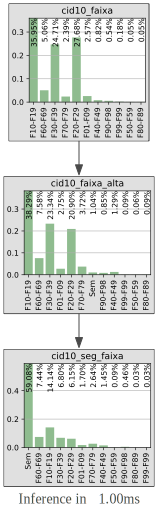

In [60]:
# Inferência da Rede
gnb.showInference(bn1)

In [61]:
# Explicabilidade da rede aprendida
gnb.flow.row(explain.getInformation(bn1))

In [62]:
# Divergências entre a rede aprendida e a rede original
gcmp=bnvsbn.GraphicalBNComparator(bn,bn1)
gnb.flow.add(bnvsbn.graphDiff(bn,bn1))
gnb.flow.add(bnvsbn.graphDiffLegend())
gnb.flow.new_line()
gnb.flow.add_html("<br/>".join([f"{k} : {v:.2f}" for k,v in gcmp.skeletonScores().items() if k!='count']),"Skeleton scores")
gnb.flow.add_html("<br/>".join([f"{k} : {v:.2f}" for k,v in gcmp.scores().items() if k!='count']),"Scores")

gnb.flow.display()

Aqui podemos notar que a rede que o modelo efetivamente aprendeu é a rede sujerida, porém com uma das arestas revertida, mostrando que é mais efetivo utilizar o diagnóstico de alta para descobrir o segundo diagnóstico do que o contrário. Uma tentativa de explicar esse fenômeno é que pessoas com determinados diagnósticos de saída entraram geralmente com mais de um diagnóstico, porém não necessariamente a informação contida no segundo diagnóstico é necessária para prever o diagnóstico de alta, dado que ele geralmente é dado pelo primeiro diagnóstico de entrada.

In [63]:
# Comparação lado a lado das redes
gnb.sideBySide(bn,bn1,gnb.getBNDiff(bn,bn1),bnvsbn.graphDiffLegend(),explain.getInformation(bn1), captions=["Rede Original","Rede Aprendida","Diferença Gráfica","Legenda","Explicabilidade"])

G <!-- cid10_faixa_alta --> cid10_faixa_alta cid10_faixa_alta <!-- cid10_faixa --> cid10_faixa cid10_faixa <!-- cid10_faixa->cid10_faixa_alta --> cid10_faixa->cid10_faixa_alta <!-- cid10_seg_faixa --> cid10_seg_faixa cid10_seg_faixa <!-- cid10_seg_faixa->cid10_faixa_alta --> cid10_seg_faixa->cid10_faixa_alta Rede Original,G <!-- cid10_faixa_alta --> cid10_faixa_alta cid10_faixa_alta <!-- cid10_seg_faixa --> cid10_seg_faixa cid10_seg_faixa <!-- cid10_faixa_alta->cid10_seg_faixa --> cid10_faixa_alta->cid10_seg_faixa <!-- cid10_faixa --> cid10_faixa cid10_faixa <!-- cid10_faixa->cid10_faixa_alta --> cid10_faixa->cid10_faixa_alta Rede Aprendida,G <!-- cid10_faixa --> cid10_faixa cid10_faixa <!-- cid10_faixa_alta --> cid10_faixa_alta cid10_faixa_alta <!-- cid10_faixa->cid10_faixa_alta --> cid10_faixa->cid10_faixa_alta <!-- cid10_seg_faixa --> cid10_seg_faixa cid10_seg_faixa <!-- cid10_faixa_alta->cid10_seg_faixa --> cid10_faixa_alta->cid10_seg_faixa <!-- cid10_seg_faixa->cid10_faixa_alta --> Diferença Gráfica,G <!-- a --> <!-- b --> <!-- a->b --> a->b overflow <!-- c --> <!-- d --> <!-- c->d --> c->d Missing <!-- e --> <!-- f --> <!-- e->f --> e->f reversed <!-- g --> <!-- h --> <!-- g->h --> g->h Correct Legenda


In [64]:
# Montagem da Rede como uma Árvore
learner=gum.BNLearner(diagnosticos,template)
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node
bntree=learner.learnBN()
bntree

(pyAgrum.BayesNet<double>@0000020BF409A780) BN{nodes: 3, arcs: 2, domainSize: 1584, dim: 263, mem: 2Ko 248o}

#### Rede amplificada

In [65]:
template_plus = gum.BayesNet('Plus')
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes']
for i in labels:
  # X_train[i].unique().tolist()
  if diagnosticos_plus[i].dtypes == 'int64':
    template_plus.add(gum.IntegerVariable(i, "", diagnosticos_plus[i].unique().tolist()))
  else:
    template_plus.add(gum.LabelizedVariable(i, "", diagnosticos_plus[i].unique().tolist()))

In [66]:

labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')
conections = ''
for i in labels2:
  conections += f'{i}->cid10_faixa_alta;'
bn_plus=gum.fastBN(conections)
gnb.showBN(bn_plus)

Aqui estão sendo utilizadas as comorbidades além dos diagnósticos para tentar encontrar o diagnóstico de alta do paciente, em uma tentativa de agregar mais informação e encontrar um classificador melhor do que anteriormente.

In [67]:
# Rede aprendida

learner = gum.BNLearner(diagnosticos_plus, template_plus)
bn2 = learner.learnBN()
bn2

(pyAgrum.BayesNet<double>@0000020BF4091060) BN{nodes: 14, arcs: 15, domainSize: 10^9.85975, dim: 512, mem: 4Ko 704o}

Novamente podemos notar que o modelo aprendido é radicamente diferente do proposto, porém pode-se tirar conclusões interessantes, podemos notar que a etnia do paciente tem influência na quantidade de vezes que ele foi internado. Também é possível inferir diversas dependências entre as comorbidades, em que a presença de uma pode indicar a presença ou ausência de outra.

In [68]:
# Probabilidades conjuntas em cid10_faixa_alta
bn2.cpt('cid10_faixa_alta')

(pyAgrum.Potential<double>@0000020BF4BDBF40) 
      ||  cid10_faixa_alta                                                                                                     |
cid10_||F10-F19  |F60-F69  |F30-F39  |F01-F09  |F20-F29  |F70-F79  |Sem      |F90-F98  |F40-F49  |F99-F99  |F50-F59  |F80-F89  |
------||---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
F10-F1|| 0.8859  | 0.0118  | 0.0311  | 0.0037  | 0.0396  | 0.0108  | 0.0051  | 0.0108  | 0.0007  | 0.0000  | 0.0000  | 0.0003  |
F60-F6|| 0.1202  | 0.5912  | 0.1899  | 0.0096  | 0.0216  | 0.0120  | 0.0120  | 0.0072  | 0.0361  | 0.0000  | 0.0000  | 0.0000  |
F30-F3|| 0.0876  | 0.1039  | 0.6922  | 0.0133  | 0.0635  | 0.0108  | 0.0074  | 0.0020  | 0.0167  | 0.0010  | 0.0015  | 0.0000  |
F70-F7|| 0.0918  | 0.0255  | 0.0510  | 0.0561  | 0.0816  | 0.6426  | 0.0204  | 0.0153  | 0.0051  | 0.0000  | 0.0000  | 0.0102  |
F20-F2|| 0.1081  | 0.0431  | 0.1266  | 0.0299  | 0.6237  | 0.0391  | 0.0132  | 0.0031  | 0.0106  | 0.0018  | 0.0000  | 0.0009  |
F01-F0|| 0.1232  | 0.0427  | 0.1090  | 0.4690  | 0.0900  | 0.0758  | 0.0664  | 0.0000  | 0.0142  | 0.0048  | 0.0000  | 0.0048  |
F40-F4|| 0.0448  | 0.2237  | 0.2088  | 0.0150  | 0.1044  | 0.0150  | 0.0001  | 0.0001  | 0.3876  | 0.0001  | 0.0001  | 0.0001  |
F90-F9|| 0.1363  | 0.0682  | 0.1136  | 0.0455  | 0.0229  | 0.1363  | 0.0229  | 0.4538  | 0.0002  | 0.0002  | 0.0002  | 0.0002  |
F99-F9|| 0.1330  | 0.0005  | 0.0668  | 0.1993  | 0.0668  | 0.3981  | 0.0005  | 0.0668  | 0.0668  | 0.0005  | 0.0005  | 0.0005  |
F50-F5|| 0.0019  | 0.2463  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.2463  | 0.0019  | 0.0019  | 0.0019  | 0.4907  | 0.0019  |
F80-F8|| 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.7352  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.0019  | 0.2463  |

Aqui novamente é possível tirar a mesma conclusão anterior, pois a rede inferiu a mesma dependência, em que o diagnóstico de alta é explicado da melhor forma utilizando o diagnóstico de entrada. A rede não inferiu uma combinação de outras features para tentar prever melhor, indicando que as comorbidades, apesar de sua grande importância na análise, não são de grande valor preditivo para chegar ao diagnóstico de alta dos pacientes.

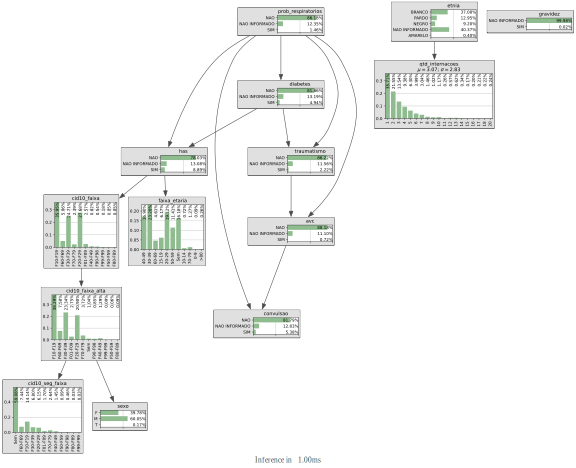

In [69]:
# Inferência da Rede
gnb.showInference(bn2)

In [70]:
# Explicabilidade da rede aprendida
gnb.flow.row(explain.getInformation(bn2))

In [71]:
# Divergências entre a rede aprendida e a rede original
gcmp=bnvsbn.GraphicalBNComparator(bn_plus,bn2)
gnb.flow.add(bnvsbn.graphDiff(bn_plus,bn2))
gnb.flow.add(bnvsbn.graphDiffLegend())
gnb.flow.new_line()
gnb.flow.add_html("<br/>".join([f"{k} : {v:.2f}" for k,v in gcmp.skeletonScores().items() if k!='count']),"Skeleton scores")
gnb.flow.add_html("<br/>".join([f"{k} : {v:.2f}" for k,v in gcmp.scores().items() if k!='count']),"Scores")

gnb.flow.display()

Aqui podemos ver que grande partes dos nós inferidos na rede proposta não foram realmente utilizados no modelo aprendido, confirmando a hipótese anterior de que o diagnóstico inicial é de grande importância para prever o resultado final, porém as comorbidades e o segundo diagnóstico não trazem muita informação adicional no contexto de previsão.

In [72]:
# Comparação lado a lado das redes
gnb.sideBySide(bn_plus,bn2,gnb.getBNDiff(bn_plus,bn2),bnvsbn.graphDiffLegend(),explain.getInformation(bn2), captions=["Rede Original","Rede Aprendida","Diferença Gráfica","Legenda","Explicabilidade"])

G <!-- a --> <!-- b --> <!-- a->b --> a->b overflow <!-- c --> <!-- d --> <!-- c->d --> c->d Missing <!-- e --> <!-- f --> <!-- e->f --> e->f reversed <!-- g --> <!-- h --> <!-- g->h --> g->h Correct Legenda


In [73]:
# Montagem da Rede como uma Árvore
learner=gum.BNLearner(diagnosticos_plus,template_plus)
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node
bntree=learner.learnBN()
bntree

(pyAgrum.BayesNet<double>@0000020BF409B320) BN{nodes: 14, arcs: 11, domainSize: 10^9.85975, dim: 464, mem: 4Ko 128o}